In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import os
from IPython.display import display

In [ ]:
raw = pd.read_csv('./DJIA_table.csv').sort_values('Date').set_index('Date')

In [ ]:
raw.head(5)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [ ]:
raw_x = raw.drop(columns={'Close'})
raw_y_open = raw[['Open']]
raw_y_close = raw[['Adj Close']]
display(raw_x.head(2))
display(raw_y_open.head(2))
display(raw_y_close.head(2))

,Open,High,Low,Volume,Adj Close
Date,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,212830000,11734.320312
2008-08-11,11729.669922,11867.110352,11675.530273,183190000,11782.349609


,Open
Date,
2008-08-08,11432.089844
2008-08-11,11729.669922


,Adj Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609


In [ ]:
# Data set preprocessing
time_step = 60
total_days = len(raw_y_open)
raw_x = raw_x.values
raw_y_open = raw_y_open.values
raw_y_close = raw_y_close.values

x = []
y_open = []
y_close = []

for i in range(time_step, total_days):
  x.append(raw_x[i-60:i])
  y_open.append(raw_y_open[i])
  y_close.append(raw_y_close[i])

x = np.array(x)
y_open = np.array(y_open)
y_close = np.array(y_close)

print(x.shape, y_open.shape, y_close.shape)

(1929, 60, 5) (1929, 1) (1929, 1)


In [ ]:
def split_test(array, spilt_day):
    
    train = array[:-spilt_day, :]
    test = array[-spilt_day:, :]
    
    return train, test

In [ ]:
split_day = 30
x_train, x_test = split_test(x, split_day)
y_open_train, y_open_test = split_test(y_open, split_day)
y_close_train, y_close_test = split_test(y_close, split_day)

print(x_train.shape, x_test.shape, y_open_train.shape, y_open_test.shape, y_close_train.shape, y_close_test.shape)

(1899, 60, 5) (30, 60, 5) (1899, 1) (30, 1) (1899, 1) (30, 1)


In [ ]:
# Model definition

# Hyperparameters
dropout_rate = 0.5
learning_rate = 0.0001

open_price_inputs = tf.keras.Input(shape=(1,), name='open_price')
inputs = tf.keras.Input(shape=(60, 5,), name='inputs')
y = tf.keras.layers.LSTM(units=50, return_sequences=True)(inputs)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.LSTM(units=50, return_sequences=True)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.LSTM(units=50)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.Dense(1)(y)
y = tf.keras.layers.Multiply()([y, open_price_inputs])
y = tf.keras.layers.Dense(100)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
# y = tf.keras.layers.BatchNormalization(axis=1)(y)
y = tf.keras.layers.Dense(1)(y)

LSTM_Model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="LSTM_Model")
LSTM_Model.summary()

Model: "LSTM_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 60, 50)       11200       inputs[0][0]                     
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 60, 50)       0           lstm_3[0][0]                     
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 60, 50)       20200       dropout_4[0][0]                  
_________________________________________________________________________________________

In [ ]:
def RootMeanSquaredError(y_actual, y_predict):
  mse = tf.keras.losses.MeanSquaredError()
  return tf.sqrt(mse(y_actual, y_predict))

LSTM_Model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = LSTM_Model.fit({'inputs': x_train, 'open_price': y_open_train}, y_close_train, batch_size=16, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
107/107 [==============================] - 5s 19ms/step - loss: 13239.3516 - root_mean_squared_error: 13266.0518 - val_loss: 14663.6133 - val_root_mean_squared_error: 14673.5195
Epoch 2/50
107/107 [==============================] - 1s 11ms/step - loss: 7279.0591 - root_mean_squared_error: 7591.4731 - val_loss: 1078.3065 - val_root_mean_squared_error: 1079.5470
Epoch 3/50
107/107 [==============================] - 1s 11ms/step - loss: 5429.7837 - root_mean_squared_error: 5556.7803 - val_loss: 198.5820 - val_root_mean_squared_error: 211.3567
Epoch 4/50
107/107 [==============================] - 1s 11ms/step - loss: 4739.9673 - root_mean_squared_error: 4821.8247 - val_loss: 194.9030 - val_root_mean_squared_error: 201.3496
Epoch 5/50
107/107 [==============================] - 1s 11ms/step - loss: 4484.9888 - root_mean_squared_error: 4558.7827 - val_loss: 165.4669 - val_root_mean_squared_error: 179.5498
Epoch 6/50
107/107 [==============================] - 1s 11ms/step - loss: 41

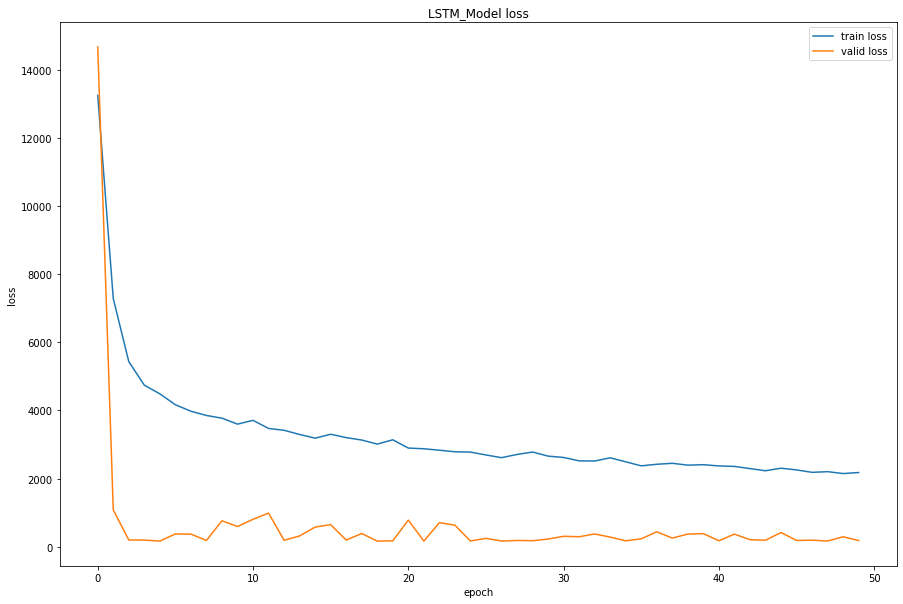

In [ ]:
# summarize history for loss
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM_Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

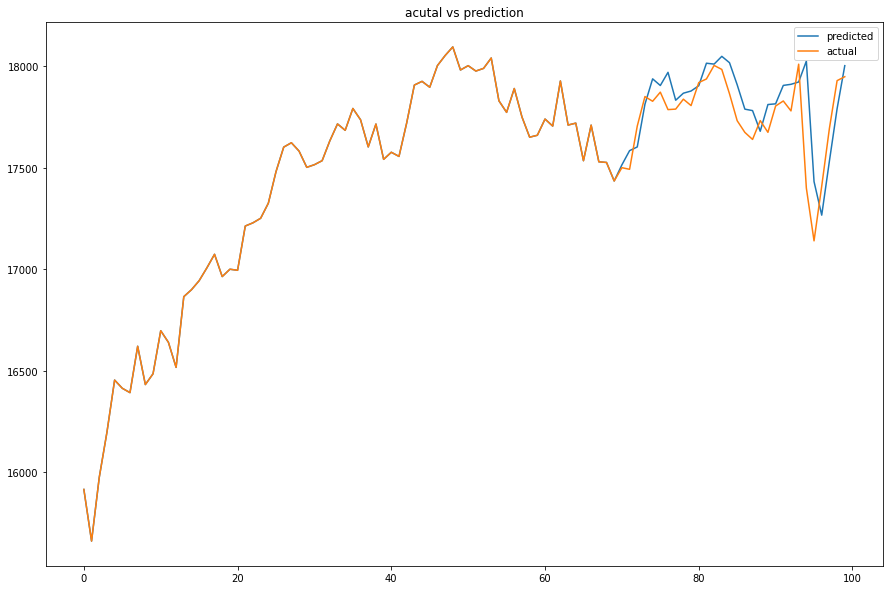

In [ ]:
background = raw['Adj Close'].iloc[-100:].to_frame()
background.index = np.arange(100)
predicted_close_price = LSTM_Model.predict([x_test, y_open_test])
predicted_close_price = np.concatenate([background.values[:70], predicted_close_price], axis=0)

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(predicted_close_price)
plt.plot(background)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [ ]:
LSTM_Model.save("./djia_lstm_model")

INFO:tensorflow:Assets written to: ./djia_lstm_model/assets


INFO:tensorflow:Assets written to: ./djia_lstm_model/assets


In [ ]:
!zip -r djia_lstm.zip ./djia_lstm_model

updating: djia_lstm_model/ (stored 0%)
updating: djia_lstm_model/keras_metadata.pb (deflated 92%)
updating: djia_lstm_model/saved_model.pb (deflated 90%)
updating: djia_lstm_model/assets/ (stored 0%)
updating: djia_lstm_model/variables/ (stored 0%)
updating: djia_lstm_model/variables/variables.data-00000-of-00001 (deflated 30%)
updating: djia_lstm_model/variables/variables.index (deflated 69%)


In [ ]:
# Areas of improvement: (2021-09-02)
# Use more sofisticated architecture/try out new techniques eg. deep RNN, GRU, diminishing learning rate, RMSprop, cross-validation
# Next-30-days prediction (sliding window)